## Module 3 Final Project Submission - Predicting Water Pump Functionality in Tanzania
* Student name: Emily J. Cain
* Student pace: Full Time
* Scheduled project review date/time: January 14, 2019
* Instructor name: Rafael Carrasco
* Blog post URL:

In [ ]:
# Notes
# create functions / loops when necessary for DRY code
# consistent header sizes, viz colors
# Permit column? 
# TSH - need to standardize?


### Sources 
* DrivenData - Data Science Competitions with Social Impact
 * https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/
* Taarifa - an open source platform that helps citizens engage with their local government
 * http://taarifa.org/
* Tanzanian Ministry of Water
 * http://maji.go.tz/

### Targets for Water Pump Functionality
* Functioning
* Functioning, in need of repair
* Non-functioning

### Data Features
* amount_tsh - total static head - amount of water available to waterpoint
* date_recorded
* funder - who funded the well
* gps_height - altitude of the well
* installer - organization that installed the well
* longitude
* latitude
* wpt_name - name of waterpoint
* num_private
* basin 
* subvillage
* region
* region_code
* district_code
* lga - geographic location
* ward - geographic location
* population
* public_meeting
* recorded_by - group that collected the data for this well
* scheme_management - who operates the waterpoint
* scheme_name
* permit
* construction_year
* extraction_type
* extraction_type_group
* extraction_type_class
* management
* payment - what the water costs
* payment_type
* water_quality
* quality_group
* quantity
* quantity_group
* source - source of the water
* source_type
* source_class
* waterpoint_type
* waterpoint_type_group

In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### I. Load & Inspect the Data

In [2]:
feature_df = pd.read_csv('waterpumpfeatures.csv')
target_df = pd.read_csv('traintargets.csv')

In [3]:
feature_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
feature_df.shape

(59400, 40)

In [5]:
target_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
target_df.shape

(59400, 2)

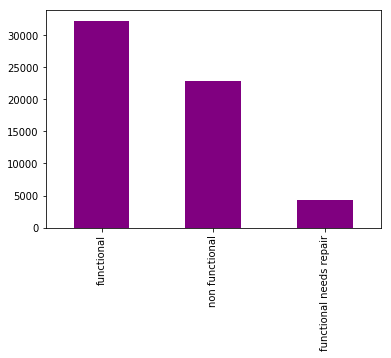

In [7]:
target_df.status_group.value_counts().plot(kind='bar', color='purple');

In [10]:
df = pd.merge(target_df, feature_df, left_index=True, right_index=True)
df.head()

,id_x,status_group,id_y,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### II. Data Cleaning & Exploratory Data Analysis

In [11]:
df.describe()

,id_x,id_y,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [12]:
df.dtypes

id_x                       int64
status_group              object
id_y                       int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management

#### Drop 'id' column

In [14]:
df.drop(['id_x', 'id_y'], axis=1, inplace=True)

In [15]:
df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


#### Check for null and placeholder values

In [16]:
df.isnull().sum()

status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [17]:
df.status_group.unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

### Funder

In [18]:
df.funder.value_counts().nlargest(50)

Government Of Tanzania            9084
Danida                            3114
Hesawa                            2202
Rwssp                             1374
World Bank                        1349
Kkkt                              1287
World Vision                      1246
Unicef                            1057
Tasaf                              877
District Council                   843
Dhv                                829
Private Individual                 826
Dwsp                               811
0                                  777
Norad                              765
Germany Republi                    610
Tcrs                               602
Ministry Of Water                  590
Water                              583
Dwe                                484
Netherlands                        470
Hifab                              450
Adb                                448
Lga                                442
Amref                              425
Fini Water               

#### Replace null and '0' values in 'funder' column with 'Unknown'

In [19]:
df.funder.fillna('Unknown', inplace=True)

In [20]:
df.funder.replace({'0': 'Unknown'}, inplace=True)

In [21]:
df.funder.value_counts().nlargest(5)

Government Of Tanzania    9084
Unknown                   4416
Danida                    3114
Hesawa                    2202
Rwssp                     1374
Name: funder, dtype: int64

### Installer

In [22]:
df.installer.value_counts().nlargest(50)

DWE                           17402
Government                     1825
RWE                            1206
Commu                          1060
DANIDA                         1050
KKKT                            898
Hesawa                          840
0                               777
TCRS                            707
Central government              622
CES                             610
Community                       553
DANID                           552
District Council                551
HESAWA                          539
World vision                    408
LGA                             408
WEDECO                          397
TASAF                           396
District council                392
Gover                           383
AMREF                           329
TWESA                           316
WU                              301
Dmdd                            287
ACRA                            278
World Vision                    270
SEMA                        

#### Replace null and '0' values in 'installer' column with 'Unknown'

In [23]:
df.installer.replace({'0': 'Unknown', np.nan: 'Unknown'}, inplace=True)

In [24]:
df.installer.value_counts().nlargest(5)

DWE           17402
Unknown        4435
Government     1825
RWE            1206
Commu          1060
Name: installer, dtype: int64

### Subvillage

In [25]:
df.subvillage.value_counts().nlargest(50)

Madukani                508
Shuleni                 506
Majengo                 502
Kati                    373
Mtakuja                 262
Sokoni                  232
M                       187
Muungano                172
Mbuyuni                 164
Mlimani                 152
Songambele              147
Msikitini               134
Miembeni                134
1                       132
Kibaoni                 114
Kanisani                111
Mapinduzi               109
I                       109
Mjimwema                108
Mjini                   108
Mkwajuni                104
Mwenge                  102
Mabatini                 98
Azimio                   98
Mbugani                  95
Mission                  95
Bwawani                  91
Bondeni                  90
Chang'Ombe               88
Zahanati                 86
Mtaa Wa Kitunda Kati     84
Kichangani               84
Senta                    84
Misufini                 83
Center                   82
Nyerere             

#### Replace null values with 'Unknown'

In [26]:
df.subvillage.fillna('Unknown', inplace=True)

In [27]:
df.subvillage.isnull().sum()

0

### Public Meeting

In [28]:
df.public_meeting.value_counts().nlargest(50)

True     51011
False     5055
Name: public_meeting, dtype: int64

#### Unclear at this time what the 'public_meeting' column represents, but will replace null values with the majority value of 'True' and change the boolean values to 0 and 1

In [35]:
df.public_meeting.replace({'True': 1, 'False': 0, np.nan: 1}, inplace=True)

In [36]:
df.public_meeting.value_counts()

True     54345
False     5055
Name: public_meeting, dtype: int64

In [37]:
df.public_meeting.head()

0    True
1       1
2    True
3    True
4    True
Name: public_meeting, dtype: object

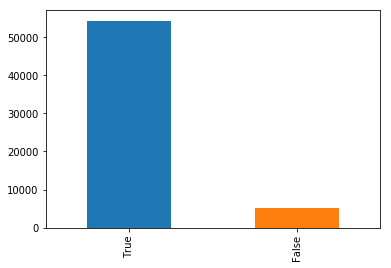

In [31]:
df.public_meeting.value_counts().plot(kind='bar');

### Scheme Management

In [52]:
feature_df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Unknown              3878
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

#### Replace null and 'None' values to 'Unknown'

In [49]:
feature_df.scheme_management.replace({'None': 'Unknown', np.nan: 'Unknown'}, inplace=True)

In [53]:
# feature_df.scheme_management.value_counts()

### Scheme Name

In [54]:
feature_df.scheme_name.value_counts().nlargest(50)

K                                        682
None                                     644
Borehole                                 546
Chalinze wate                            405
M                                        400
DANIDA                                   379
Government                               320
Ngana water supplied scheme              270
wanging'ombe water supply s              261
wanging'ombe supply scheme               234
Bagamoyo wate                            229
I                                        229
Uroki-Bomang'ombe water sup              209
N                                        204
Kirua kahe gravity water supply trust    193
Machumba estate pipe line                185
Makwale water supplied sche              166
Kijiji                                   161
S                                        154
Handeni Trunk Main(H                     152
Losaa-Kia water supply                   152
mtwango water supply scheme              152
Mkongoro T

#### Replace null and 'None' values to 'Unknown'

In [55]:
feature_df.scheme_name.replace({np.nan: 'Unknown', 'None': 'Unknown'}, inplace=True)

In [56]:
feature_df.scheme_name.value_counts().nlargest(5)

Unknown          28810
K                  682
Borehole           546
Chalinze wate      405
M                  400
Name: scheme_name, dtype: int64

### Permit

In [57]:
feature_df.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

#### Change null values to 'Unknown' at this time

In [63]:
feature_df.permit.fillna('Unknown', inplace=True)

In [64]:
feature_df.isnull().sum()

amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
w

### Amount TSH (Total static head)

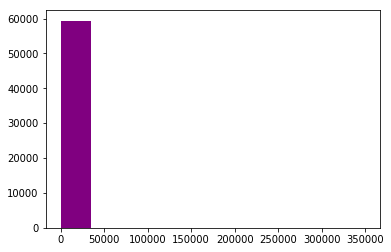

In [75]:
plt.hist(feature_df.amount_tsh, color='purple');

In [79]:
# feature_df.amount_tsh.value_counts().nlargest(50)

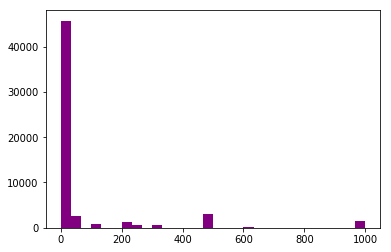

In [76]:
plt.hist(feature_df.amount_tsh, color='purple', range=(0,1000), bins=30);

### Date Recorded

In [80]:
date_df = feature_df[['date_recorded', 'construction_year']]

In [82]:
date_df.head(15)

,date_recorded,construction_year
0,2011-03-14,1999
1,2013-03-06,2010
2,2013-02-25,2009
3,2013-01-28,1986
4,2011-07-13,0
5,2011-03-13,2009
6,2012-10-01,0
7,2012-10-09,0
8,2012-11-03,0
9,2011-08-03,0


In [83]:
date_df.tail(15)

,date_recorded,construction_year
59385,2012-11-03,2011
59386,2011-08-22,2009
59387,2013-03-12,2000
59388,2013-01-29,1995
59389,2011-08-06,2009
59390,2011-08-04,1991
59391,2013-08-03,1967
59392,2011-04-15,0
59393,2012-10-27,0
59394,2011-03-09,2007
